## Look at the data

In [1]:
#Add the current path into the system path
import sys,os
curPath = os.path.abspath(os.path.dirname("/home/murrawang/"))
sys.path.append(curPath)

# Import necessary libraries
from pyspark.sql import SQLContext
import graphframes
from graphframes import *
from AggregateMessages import *

import matplotlib.pyplot as plt
%matplotlib inline

from pyspark.sql.functions import col, lit, when, avg, collect_list, mean, row_number
from pyspark.sql import Row
from pyspark.sql.window import Window

from datetime import datetime
import numpy as np

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

In [2]:
#Yelp business data
business_path = "hdfs:///yelp/yelp_academic_dataset_business.json"
yelp_business = spark.read.json(business_path)
# Check which states Yelp concentrates on
yelp_business.select("state").rdd.map(lambda x: (x, 1)).reduceByKey(lambda x,y : x+y).collect()

[(Row(state=u'AZ'), 2),
 (Row(state=u'MN'), 1),
 (Row(state=u'BC'), 17298),
 (Row(state=u'DE'), 1),
 (Row(state=u'OH'), 11258),
 (Row(state=u'NC'), 1),
 (Row(state=u'HI'), 1),
 (Row(state=u'NH'), 4),
 (Row(state=u'FL'), 21907),
 (Row(state=u'OK'), 1),
 (Row(state=u'CO'), 3198),
 (Row(state=u'KS'), 1),
 (Row(state=u'ME'), 1),
 (Row(state=u'MI'), 1),
 (Row(state=u'MA'), 36012),
 (Row(state=u'IL'), 1),
 (Row(state=u'ON'), 2),
 (Row(state=u'VA'), 2),
 (Row(state=u'OR'), 25175),
 (Row(state=u'NM'), 1),
 (Row(state=u'ABE'), 1),
 (Row(state=u'NY'), 2),
 (Row(state=u'AL'), 1),
 (Row(state=u'DC'), 1),
 (Row(state=u'KY'), 1),
 (Row(state=u'GA'), 18090),
 (Row(state=u'WY'), 1),
 (Row(state=u'CA'), 13),
 (Row(state=u'WA'), 3121),
 (Row(state=u'WI'), 1),
 (Row(state=u'TX'), 24485)]

In [3]:
# Here I select businesses in Washington state
# I drop the businesses which have fewer than 15 reviews to reduce the sparseness.
yelp_business = yelp_business.filter((yelp_business["state"] == "WA") & (yelp_business["review_count"] >= 15)).distinct()
yelp_business.show(5)

+--------------------+--------------------+--------------------+--------------------+---------+--------------------+-------+----------+------------+----------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|     city|               hours|is_open|  latitude|   longitude|            name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+---------+--------------------+-------+----------+------------+----------------+-----------+------------+-----+-----+
|   6115 NE 114th Ave|[,,,,,,, False,, ...|SGjpAM8p8KbOCoHwn...|Tanning Beds, Tan...|Vancouver|[10:0-21:0, 10:0-...|      0|45.6675307|-122.5560289|    Tan Republic|      98662|          18|  2.0|   WA|
|705 SE Park Crest...|[,,,,,,,,, True,,...|lxqrD1JmANEpGjH_2...|Automotive, Car Wash|Vancouver|                null|      1|  45.61728| -122.522021|Thunder Car Wash|      98683|          1

In [4]:
yelp_business.printSchema()

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

In [5]:
yelp_business.count()

1589

In [6]:
#Yelp review data
review_path = "hdfs:///yelp/yelp_academic_dataset_review.json"
yelp_review = spark.read.json(review_path)
# Here I only choose reviews on businesses in Washington state
# I apply "dropDuplicates" so that a user only gives one review to a particular business, otherwise our prediction may 
# diverge since the sum of the similarities can exceed one.
yelp_review = yelp_review.join(yelp_business, "business_id", "right").\
                    select("business_id", "user_id", yelp_review.stars).dropDuplicates(["business_id", "user_id"])
yelp_review.show(5)

+--------------------+--------------------+-----+
|         business_id|             user_id|stars|
+--------------------+--------------------+-----+
|-36nnCT71XE0InJXK...|5x8qXbNqCgOCBTKDV...|  1.0|
|-36nnCT71XE0InJXK...|Hi_DpLJZIzCEARnK2...|  4.0|
|-36nnCT71XE0InJXK...|7iqFv70W9hQ76RtBk...|  1.0|
|-36nnCT71XE0InJXK...|cPcOrTSpfHf3AZDyz...|  1.0|
|-36nnCT71XE0InJXK...|1q_CCZlkcE_oihpIP...|  1.0|
+--------------------+--------------------+-----+
only showing top 5 rows



In [7]:
yelp_review.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- stars: double (nullable = true)



In [8]:
yelp_review.count()

102383

In [9]:
#save the review dataset
yelp_review.write.save("hdfs:///yelp/yelp_review.json", format="json")

## Loading the small datasets

In [10]:
#Add the current path into the system path
import sys,os
curPath = os.path.abspath(os.path.dirname("/home/murrawang/"))
sys.path.append(curPath)

# Import necessary libraries
from pyspark.sql import SQLContext
import graphframes
from graphframes import *
from AggregateMessages import *

import matplotlib.pyplot as plt
%matplotlib inline

from pyspark.sql.functions import col, lit, when, avg, collect_list, mean, row_number
from pyspark.sql import Row
from pyspark.sql.window import Window

from datetime import datetime
import numpy as np

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

In [11]:
#loading the target dataset
review_path = "hdfs:///yelp/yelp_review.json"
yelp_review = spark.read.json(review_path)

In [12]:
# ALS algorithm needs IDs to be numerical type, so I transfer the string type ID to the numerical type ID.
w = Window().orderBy(lit('A'))
yelp_user_with_numid = yelp_review.select("user_id").distinct().withColumn("user_numid", row_number().over(w))
yelp_business_with_numid = yelp_review.select("business_id").distinct().withColumn("business_numid", row_number().over(w))
yelp_review = yelp_review.join(yelp_user_with_numid, "user_id", "left").join(yelp_business_with_numid, "business_id", "left")

In [13]:
yelp_review.show(5)

+--------------------+--------------------+-----+----------+--------------+
|         business_id|             user_id|stars|user_numid|business_numid|
+--------------------+--------------------+-----+----------+--------------+
|09ynzfWNP6r0QjO9p...|0HLF7616Cjh13eePw...|  5.0|     36798|          1489|
|09ynzfWNP6r0QjO9p...|XKxCQWiePGLsMRXB-...|  4.0|     40416|          1489|
|09ynzfWNP6r0QjO9p...|aJwAQr0HzTqsPwIvW...|  5.0|     34973|          1489|
|09ynzfWNP6r0QjO9p...|ti2Ls9kn7GcPZPVnC...|  5.0|     38182|          1489|
|09ynzfWNP6r0QjO9p...|R2l6KxmYx_fIby80Z...|  5.0|     21797|          1489|
+--------------------+--------------------+-----+----------+--------------+
only showing top 5 rows



In [14]:
# split the review data to training and test parts
(training_r, test_r) = yelp_review.randomSplit([0.8, 0.2], seed=11)
training_r.cache()
test_r.cache()
print('Number of partitions: ', training_r.rdd.getNumPartitions())
print('Number of workers:', int(sc._conf.get('spark.executor.instances')))

('Number of partitions: ', 7)
('Number of workers:', 2)


In [15]:
yelp_review.count()

102383

In [16]:
training_r.count()

81978

In [17]:
test_r.count()

20405

## Hyperparameters Selection for ALS Model

In [27]:
# Choose the LatentFactors and maxIterations (regularization parameter = 0.1)
rmserrors = {}
for numberLatentFactors in range(1,11):
    for maxIterations in range(5,11):
        als = ALS(rank=numberLatentFactors, maxIter=maxIterations, regParam=0.1, 
          userCol="user_numid", itemCol="business_numid", ratingCol="stars", 
          coldStartStrategy="drop")

        model = als.fit(training_r)
    
        predictions = model.transform(test_r)

        evaluator = RegressionEvaluator(metricName="rmse", 
                                labelCol="stars", predictionCol="prediction")

        rmse = evaluator.evaluate(predictions)
        
        print("latent factors: ", numberLatentFactors)
        print("max iterations: ", maxIterations)
        rmserrors[(numberLatentFactors,maxIterations)] = rmse

        print("Root-mean-square error = " + str(rmse))

('latent factors: ', 1)
('max iterations: ', 5)
Root-mean-square error = 5.34834780492
('latent factors: ', 1)
('max iterations: ', 6)
Root-mean-square error = 5.58164546264
('latent factors: ', 1)
('max iterations: ', 7)
Root-mean-square error = 5.83122430407
('latent factors: ', 1)
('max iterations: ', 8)
Root-mean-square error = 6.08910900309
('latent factors: ', 1)
('max iterations: ', 9)
Root-mean-square error = 6.32663762793
('latent factors: ', 1)
('max iterations: ', 10)
Root-mean-square error = 6.54538858774
('latent factors: ', 2)
('max iterations: ', 5)
Root-mean-square error = 4.36980879436
('latent factors: ', 2)
('max iterations: ', 6)
Root-mean-square error = 3.74618313255
('latent factors: ', 2)
('max iterations: ', 7)
Root-mean-square error = 3.24876791
('latent factors: ', 2)
('max iterations: ', 8)
Root-mean-square error = 2.90187284596
('latent factors: ', 2)
('max iterations: ', 9)
Root-mean-square error = 2.67928136977
('latent factors: ', 2)
('max iterations: ', 

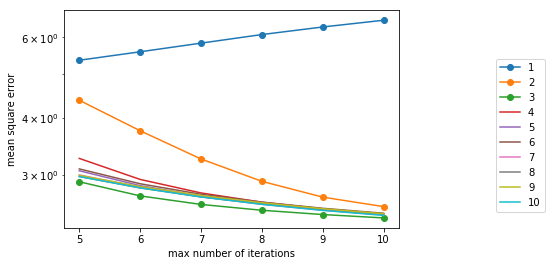

In [28]:
#### plotting ####
maxiter = list(set([x[1] for x in rmserrors.keys()]))
numberLatentFactors = list(set([x[0] for x in rmserrors.keys()]))

for numberLatentFactors in range(1,11):
    currenrmse = [rmserrors[numberLatentFactors,m] for m in maxiter]
    if numberLatentFactors in [1,2,3]:
        plt.plot(maxiter,currenrmse,'o-',label=numberLatentFactors)
    else:
        plt.plot(maxiter,currenrmse,label=numberLatentFactors)
    plt.xlabel('max number of iterations')
    plt.ylabel('mean square error')
plt.yscale('log')
plt.legend(loc='upper right', bbox_to_anchor=(1.45, 0.8))
plt.show()

In [29]:
# Choose the LatentFactors and maxIterations (regularization parameter = 0.5)
rmserrors = {}
for numberLatentFactors in range(1,11):
    for maxIterations in range(5,11):
        als = ALS(rank=numberLatentFactors, maxIter=maxIterations, regParam=0.5, 
          userCol="user_numid", itemCol="business_numid", ratingCol="stars", 
          coldStartStrategy="drop")

        model = als.fit(training_r)
    
        predictions = model.transform(test_r)

        evaluator = RegressionEvaluator(metricName="rmse", 
                                labelCol="stars", predictionCol="prediction")

        rmse = evaluator.evaluate(predictions)
        
        print("latent factors: ", numberLatentFactors)
        print("max iterations: ", maxIterations)
        rmserrors[(numberLatentFactors,maxIterations)] = rmse

        print("Root-mean-square error = " + str(rmse))

('latent factors: ', 1)
('max iterations: ', 5)
Root-mean-square error = 4.5471154694
('latent factors: ', 1)
('max iterations: ', 6)
Root-mean-square error = 4.44729525722
('latent factors: ', 1)
('max iterations: ', 7)
Root-mean-square error = 4.30800308333
('latent factors: ', 1)
('max iterations: ', 8)
Root-mean-square error = 4.10388746578
('latent factors: ', 1)
('max iterations: ', 9)
Root-mean-square error = 3.90395492094
('latent factors: ', 1)
('max iterations: ', 10)
Root-mean-square error = 3.7344115513
('latent factors: ', 2)
('max iterations: ', 5)
Root-mean-square error = 3.46741071942
('latent factors: ', 2)
('max iterations: ', 6)
Root-mean-square error = 2.79820860364
('latent factors: ', 2)
('max iterations: ', 7)
Root-mean-square error = 2.40118412451
('latent factors: ', 2)
('max iterations: ', 8)
Root-mean-square error = 2.21366388632
('latent factors: ', 2)
('max iterations: ', 9)
Root-mean-square error = 2.11609102163
('latent factors: ', 2)
('max iterations: ',

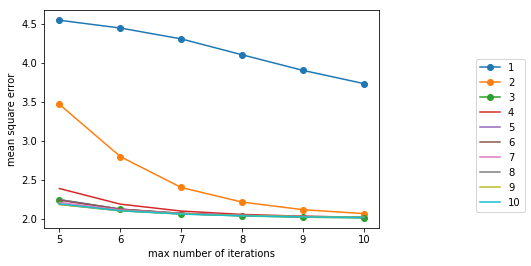

In [32]:
#### plotting ####
maxiter = list(set([x[1] for x in rmserrors.keys()]))
numberLatentFactors = list(set([x[0] for x in rmserrors.keys()]))

for numberLatentFactors in range(1,11):
    currenrmse = [rmserrors[numberLatentFactors,m] for m in maxiter]
    if numberLatentFactors in [1,2,3]:
        plt.plot(maxiter,currenrmse,'o-',label=numberLatentFactors)
    else:
        plt.plot(maxiter,currenrmse,label=numberLatentFactors)
    plt.xlabel('max number of iterations')
    plt.ylabel('mean square error')
plt.legend(loc='upper right', bbox_to_anchor=(1.45, 0.8))
plt.show()

In [33]:
# Choose the LatentFactors and maxIterations (regularization parameter = 1)
rmserrors = {} 
for numberLatentFactors in range(1,11):
    for maxIterations in range(5,11):
        als = ALS(rank=numberLatentFactors, maxIter=maxIterations, regParam=1, 
          userCol="user_numid", itemCol="business_numid", ratingCol="stars", 
          coldStartStrategy="drop")

        model = als.fit(training_r)
    
        predictions = model.transform(test_r)

        evaluator = RegressionEvaluator(metricName="rmse", 
                                labelCol="stars", predictionCol="prediction")

        rmse = evaluator.evaluate(predictions)
        
        print("latent factors: ", numberLatentFactors)
        print("max iterations: ", maxIterations)
        rmserrors[(numberLatentFactors,maxIterations)] = rmse

        print("Root-mean-square error = " + str(rmse))

('latent factors: ', 1)
('max iterations: ', 5)
Root-mean-square error = 3.98479464752
('latent factors: ', 1)
('max iterations: ', 6)
Root-mean-square error = 3.71657330555
('latent factors: ', 1)
('max iterations: ', 7)
Root-mean-square error = 3.43004897998
('latent factors: ', 1)
('max iterations: ', 8)
Root-mean-square error = 3.18952466724
('latent factors: ', 1)
('max iterations: ', 9)
Root-mean-square error = 2.97674313672
('latent factors: ', 1)
('max iterations: ', 10)
Root-mean-square error = 2.84863136047
('latent factors: ', 2)
('max iterations: ', 5)
Root-mean-square error = 3.47422288122
('latent factors: ', 2)
('max iterations: ', 6)
Root-mean-square error = 2.82793779448
('latent factors: ', 2)
('max iterations: ', 7)
Root-mean-square error = 2.43181886715
('latent factors: ', 2)
('max iterations: ', 8)
Root-mean-square error = 2.24976718606
('latent factors: ', 2)
('max iterations: ', 9)
Root-mean-square error = 2.15923752818
('latent factors: ', 2)
('max iterations: 

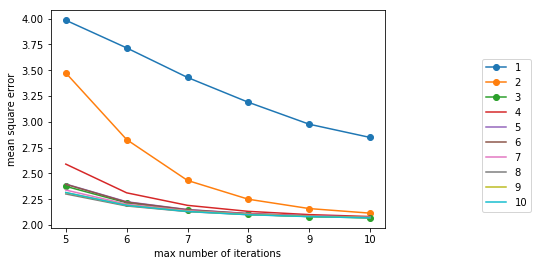

In [34]:
#### plotting ####
maxiter = list(set([x[1] for x in rmserrors.keys()]))
numberLatentFactors = list(set([x[0] for x in rmserrors.keys()]))

for numberLatentFactors in range(1,11):
    currenrmse = [rmserrors[numberLatentFactors,m] for m in maxiter]
    if numberLatentFactors in [1,2,3]:
        plt.plot(maxiter,currenrmse,'o-',label=numberLatentFactors)
    else:
        plt.plot(maxiter,currenrmse,label=numberLatentFactors)
    plt.xlabel('max number of iterations')
    plt.ylabel('mean square error')
plt.legend(loc='upper right', bbox_to_anchor=(1.45, 0.8))
plt.show()

From above, we can see the models with regularization parameter equaling to 0.5 perform better so we set our regularization parameter to 0.5 for the following analysis. The result also indicates that the RMSE decreases as the max number of iterations increases. Therefore, I continue to move the grid of iterations forward. 

In [35]:
# Choose the LatentFactors and maxIterations (regularization parameter = 0.5)
rmserrors = {}
for numberLatentFactors in range(1,11):
    for maxIterations in range(10,15):
        als = ALS(rank=numberLatentFactors, maxIter=maxIterations, regParam=0.5, 
          userCol="user_numid", itemCol="business_numid", ratingCol="stars", 
          coldStartStrategy="drop")

        model = als.fit(training_r)
    
        predictions = model.transform(test_r)

        evaluator = RegressionEvaluator(metricName="rmse", 
                                labelCol="stars", predictionCol="prediction")

        rmse = evaluator.evaluate(predictions)
        
        print("latent factors: ", numberLatentFactors)
        print("max iterations: ", maxIterations)
        rmserrors[(numberLatentFactors,maxIterations)] = rmse

        print("Root-mean-square error = " + str(rmse))

('latent factors: ', 1)
('max iterations: ', 10)
Root-mean-square error = 3.7344115513
('latent factors: ', 1)
('max iterations: ', 11)
Root-mean-square error = 3.59036923686
('latent factors: ', 1)
('max iterations: ', 12)
Root-mean-square error = 3.48514063705
('latent factors: ', 1)
('max iterations: ', 13)
Root-mean-square error = 3.37819770704
('latent factors: ', 1)
('max iterations: ', 14)
Root-mean-square error = 3.29024711403
('latent factors: ', 2)
('max iterations: ', 10)
Root-mean-square error = 2.06594889959
('latent factors: ', 2)
('max iterations: ', 11)
Root-mean-square error = 2.04164568328
('latent factors: ', 2)
('max iterations: ', 12)
Root-mean-square error = 2.02778825698
('latent factors: ', 2)
('max iterations: ', 13)
Root-mean-square error = 2.01944698069
('latent factors: ', 2)
('max iterations: ', 14)
Root-mean-square error = 2.01469565227
('latent factors: ', 3)
('max iterations: ', 10)
Root-mean-square error = 2.01043901153
('latent factors: ', 3)
('max ite

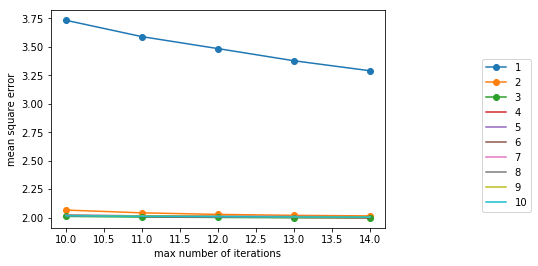

In [36]:
#### plotting ####
maxiter = list(set([x[1] for x in rmserrors.keys()]))
numberLatentFactors = list(set([x[0] for x in rmserrors.keys()]))

for numberLatentFactors in range(1,11):
    currenrmse = [rmserrors[numberLatentFactors,m] for m in maxiter]
    if numberLatentFactors in [1,2,3]:
        plt.plot(maxiter,currenrmse,'o-',label=numberLatentFactors)
    else:
        plt.plot(maxiter,currenrmse,label=numberLatentFactors)
    plt.xlabel('max number of iterations')
    plt.ylabel('mean square error')
plt.legend(loc='upper right', bbox_to_anchor=(1.45, 0.8))
plt.show()

The result shows that the RMSE decreases very slowly after 10 iterations so I think it is very close to the optimum. Since the model with 3 latent factors and 14 iterations gives the best RMSE, the model is finally selected.

## Build the recommendation system model using ALS

In [38]:
numberLatentFactors = 3 # specify how many latent factors to use
# the "coldStartStrategy" is set to drop to ensure that we don't get NaN evaluation metrics
als = ALS(rank=numberLatentFactors, maxIter=14, regParam=0.5, 
          userCol="user_numid", itemCol="business_numid", ratingCol="stars", 
          coldStartStrategy="drop")

model = als.fit(training_r)
# note that running the training on the full data set takes a while!

In [39]:
# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test_r)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="stars", predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 1.99697062952
